In [1]:
#Imports
import plotly.figure_factory as ff
import plotly.express as px  
import plotly.graph_objects as go
import pandas as pd
import googlemaps
import numpy as np
import pprint
import time
from scipy import stats
import random
import datetime
from pymongo import MongoClient
import matplotlib.pyplot as plt
from IPython.display import clear_output
import dash  # (version 1.12.0) pip install dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

_______________________________________________________
# Import Relevant Information from US Dept Energy
____________________________________________________________

In [2]:
#Read in Energy Dept Info on Electric Car Recharging Stations
recharge_station_data = pd.read_csv('CSV_Files/alt_fuel_stations (Oct 23 2020).csv')

/home/louisbove84/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (6,16,20,33,39,40,41,43,49,55,57,58,60,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Show all data obtained from US Department of Energy 
#recharge_station_data.info()

In [4]:
#Only include electric charging stations in the DataFrame
station_db = recharge_station_data[recharge_station_data['Fuel Type Code']=='ELEC']

#Remove Canada from DataFrame
station_db = station_db[station_db['Country']=='US']

#Drop irrelevant columns
station_db = station_db.iloc[:, [1,2,4,5,6,18,19,21,24,25,32,37,47,54]]

#Convert Lat-Long data into a readable format for Google API
station_db['Latitude'] = station_db['Latitude'].astype(str)
station_db['Longitude'] = station_db['Longitude'].astype(str) 
station_db['lat_long'] = station_db['Latitude'] + ',' + station_db['Longitude']

#Merge Station Name, Street Address, City, and State code for Google API
station_db['full_address'] = station_db['Station Name'] + ' ' + station_db['Street Address'] + ' ' + station_db['City'] + ' ' + station_db['State']

#Create 'Open Datetime' column converted from non-datatime column 'Open Date' 
station_db['Open Datetime'] = pd.to_datetime(station_db['Open Date'].str.replace('-',''))

#Replace 'Tesla Destination' string with 'Tesla'
station_db['EV Network'] = station_db['EV Network'].replace(['Tesla Destination'],'Tesla')

In [5]:
#View all info from the corrected dataframe
#station_db.info()
#station_db[station_db['Facility Type']=='HOTEL'].info()
#station_db['EV Pricing'].value_counts().head(5)

______________________________________________________
# Exploratory Data Analysis
_________________________________________________

## 1. Charging Stations by State

No handles with labels found to put in legend.


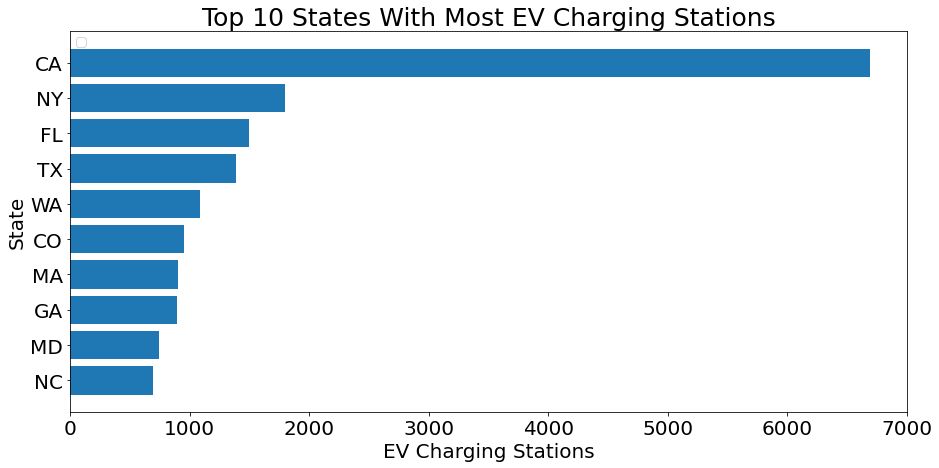

In [6]:
#Create Figure
fig, ax1 = plt.subplots(figsize=(15,7))

#Total station by state
tot_st = station_db['State'].value_counts().head(10)
ax1.barh(tot_st.index, tot_st.values)
ax1.set_xlabel('EV Charging Stations', size = 20)
ax1.set_ylabel('State', size = 20)
ax1.set_title('Top 10 States With Most EV Charging Stations', size = 25)
ax1.legend(loc=2, prop={'size': 12})
ax1.invert_yaxis()
ax1.set_xlim(0,7000)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax1.grid()

## 2. Top 2 EV Network Total Charging Ports

No handles with labels found to put in legend.
No handles with labels found to put in legend.


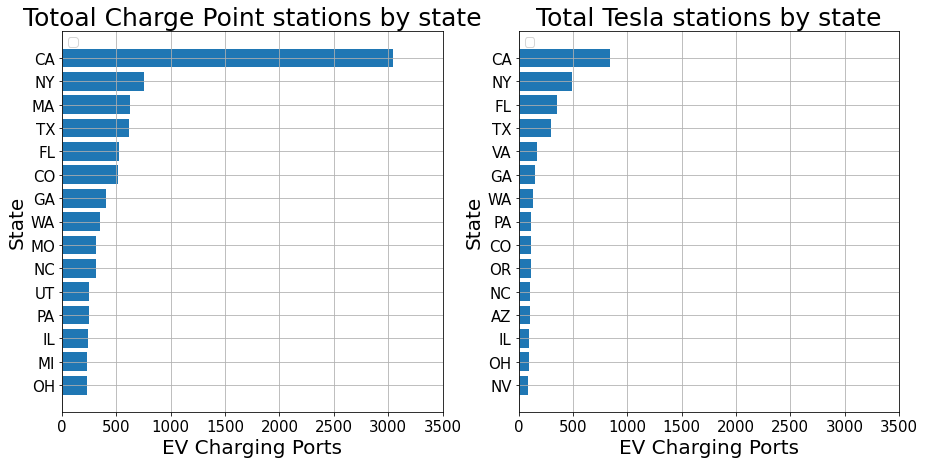

In [7]:
#Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(15,7), sharex=True, sharey=False)

#Charge Point station by state
chpt_st = station_db[station_db['EV Network']=='ChargePoint Network']['State'].value_counts().head(15)
ax[0].barh(chpt_st.index, chpt_st.values)
ax[0].set_xlabel('EV Charging Ports', size = 20)
ax[0].set_ylabel('State', size = 20)
ax[0].set_title('Totoal Charge Point stations by state', size = 25)
ax[0].legend(loc=2, prop={'size': 12})
ax[0].invert_yaxis()
ax[0].set_xlim(0,3500)
ax[0].grid()
ax[0].tick_params(axis='both', which='major', labelsize=15)

#Tesla station by state
tsla_st = station_db[station_db['EV Network']=='Tesla']['State'].value_counts().head(15)
ax[1].barh(tsla_st.index, tsla_st.values)
ax[1].set_xlabel('EV Charging Ports', size = 20)
ax[1].set_ylabel('State', size = 20)
ax[1].set_title('Total Tesla stations by state', size = 25)
ax[1].legend(loc=2, prop={'size': 12})
ax[1].invert_yaxis()
ax[1].set_xlim(0,3500)
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=15)

## 3. Top EV Networks by Total Charging Ports

(0.0, 40000.0)

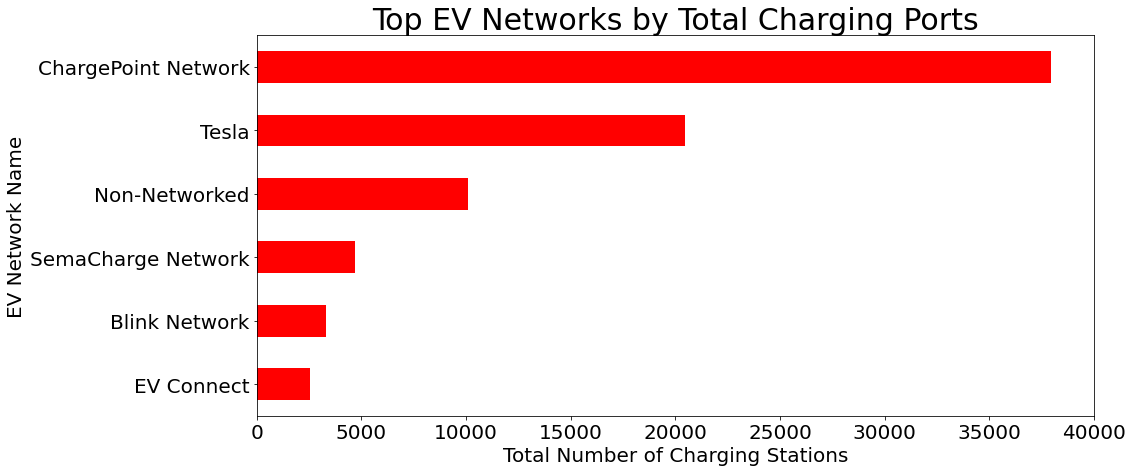

In [8]:
#Plotting total charging ports by EV Network
charge_ports = station_db.groupby('EV Network')['EV Level2 EVSE Num'].sum().sort_values(ascending = False) + station_db.groupby('EV Network')['EV DC Fast Count'].sum().sort_values(ascending = False)
fig, ax = plt.subplots(figsize=(15,7))
charge_ports.sort_values(ascending = False)[0:6].plot(kind='barh', color='r')
plt.xlabel('Total Number of Charging Stations', size = 20)
plt.ylabel('EV Network Name', size = 20)
plt.title('Top EV Networks by Total Charging Ports', size = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.gca().invert_yaxis()
plt.xlim(0,40000)

## 4. Top EV Networks for Level 2/Level 3 Total Charging Ports

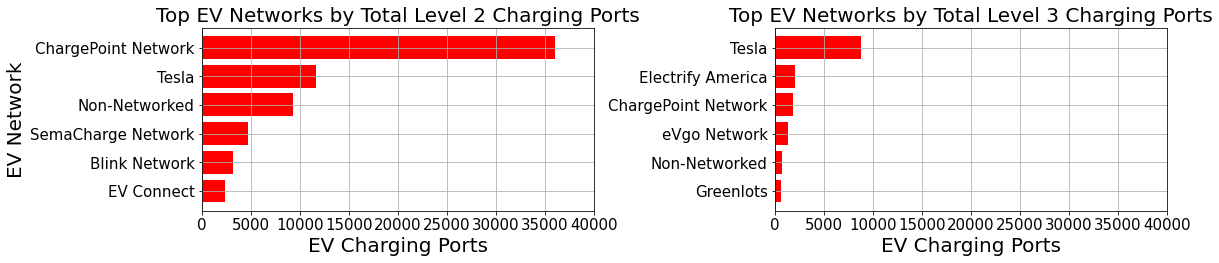

In [9]:
#Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,7), sharex=True, sharey=False)
fig.tight_layout(pad=15.0)

#Top 5 total charging stations by EV Network
charge_ports2 = station_db.groupby('EV Network')['EV Level2 EVSE Num'].sum().sort_values(ascending = False)[0:6]

ax[0].barh(charge_ports2.index, charge_ports2.values, color='r')
ax[0].set_xlabel('EV Charging Ports', size = 20)
ax[0].set_ylabel('EV Network', size = 20)
ax[0].set_title('Top EV Networks by Total Level 2 Charging Ports', size = 20)
ax[0].invert_yaxis()
ax[0].set_xlim(0, 40000)
ax[0].grid()
ax[0].tick_params(axis='both', which='major', labelsize=15)

#Tesla station by state
charge_ports3 = station_db.groupby('EV Network')['EV DC Fast Count'].sum().sort_values(ascending = False)[0:6]

ax[1].barh(charge_ports3.index, charge_ports3.values, color='r')
ax[1].set_xlabel('EV Charging Ports', size = 20)
ax[1].set_title('Top EV Networks by Total Level 3 Charging Ports', size = 20)
ax[1].invert_yaxis()
ax[1].set_xlim(0,40000)
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=15)

## 5. Top EV Networks by Total Charging Stations

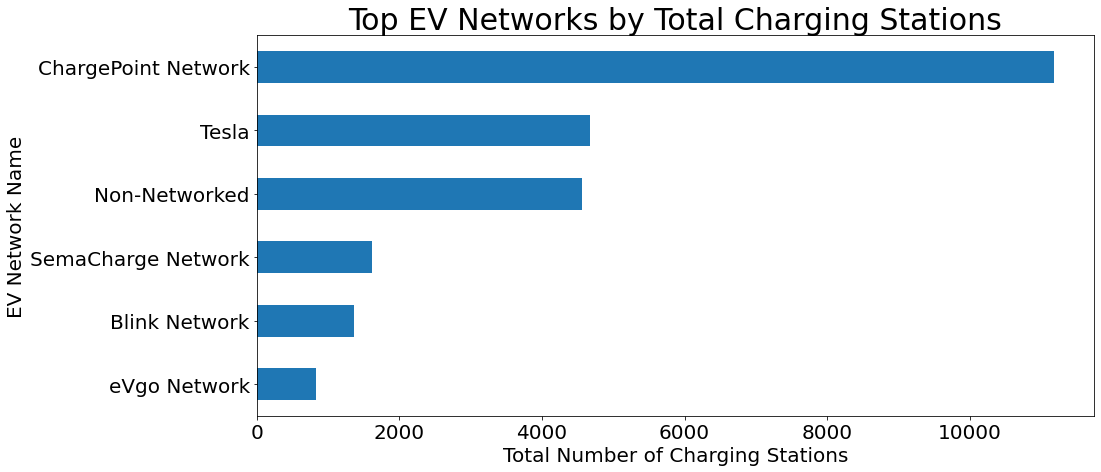

In [10]:
#Top 5 total charging stations by EV Network
fig, ax = plt.subplots(figsize=(15,7))
station_db['EV Network'].value_counts()[0:6].plot(kind='barh')
plt.xlabel('Total Number of Charging Stations', size = 20)
plt.ylabel('EV Network Name', size = 20)
plt.title('Top EV Networks by Total Charging Stations', size = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.gca().invert_yaxis()

## 6. Top EV Charging Station Locations

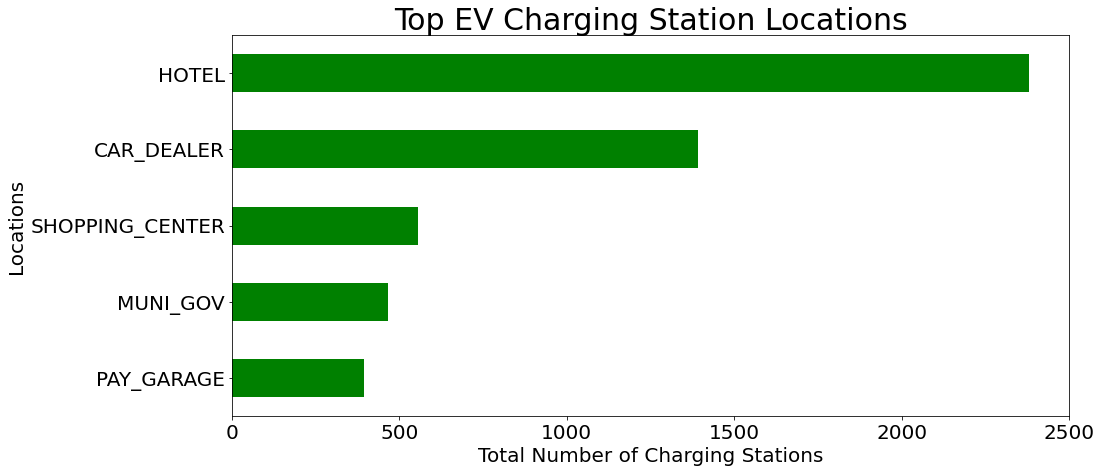

In [11]:
#Top 5 locations where charging stations are located by total number
fig, ax = plt.subplots(figsize=(15,7))
station_db['Facility Type'].value_counts()[0:5].plot(kind='barh', color='g')
plt.xlabel('Total Number of Charging Stations', size = 20)
plt.ylabel('Locations', size = 20)
plt.title('Top EV Charging Station Locations', size = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.gca().invert_yaxis()

## 7. Top EV Charging Stations Located at Hotels

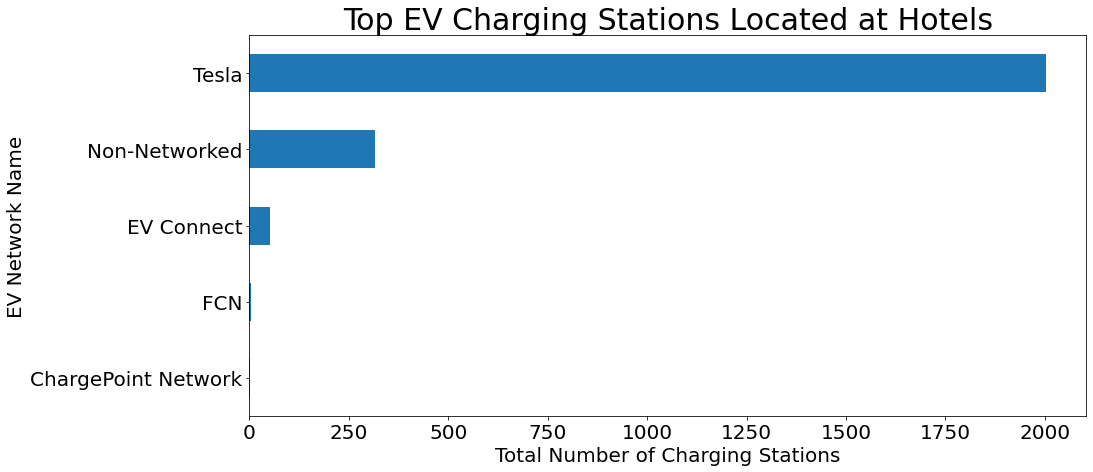

In [12]:
#Top EV Networks located at a hotel
fig, ax = plt.subplots(figsize=(15,7))
station_db[station_db['Facility Type']=='HOTEL']['EV Network'].value_counts()[0:5].plot(kind='barh')
plt.xlabel('Total Number of Charging Stations', size = 20)
plt.ylabel('EV Network Name', size = 20)
plt.title('Top EV Charging Stations Located at Hotels', size = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.gca().invert_yaxis()

___________________________________________________________
# Extract Ratings Data from API and Import/Export to/from MongoDB
___________________________________________________________

In [13]:
#EV Networks located in a hotel parking lot
station_db_hotel = station_db[station_db['Facility Type']=='HOTEL'].iloc[:, [7,11,14,15]]

#Observe the data needed to use the Google API
#station_db_hotel.info()

In [14]:
#Define API Client to interact with Google 
#gmaps = googlemaps.Client(key='Key')

#Connect to MongoDB container on Docker 
myclient = MongoClient('localhost', 27017)

#Create database variable from Mongo DB
mongo_hotels_database = myclient.db_hotels

#Create collection variable from Mongo DB
mongo_hotels_collection = mongo_hotels_database.collection_hotels

In [ ]:
#Results counter
rslts_cntr = 0

#Loop through 2000 random rows and feed the data into Google API
for index, row in station_db_hotel.sample(2000).iterrows():

    #Clear counter
    clear_output(wait=True)
    
    #Search Google API for 'Place ID'
    hotel_id = gmaps.find_place(input = row.full_address, input_type = 'textquery')
    
    #Create variable for the place_id
    try:
        id_num = hotel_id['candidates'][0]['place_id']
    except IndexError:
        id_num = 'null'
    
    #Use 'Place ID' to find further details of hotel
    if id_num == 'null':
        pass
    else:
        hotel_details = gmaps.place(place_id = id_num)
    
    #Load data into MongoDB
    if id_num == 'null':
        pass
    else:
        if not mongo_hotels_collection.find_one(hotel_details['result']):
            mongo_hotels_collection.insert_one(hotel_details['result'])
    
    #Iterate Counter
    rslts_cntr += 1
    
    #Print current progress
    print("Currently collecting data on row: {}".format(rslts_cntr))
    
    #Print each input as it is created
    #pprint.pprint(hotel_details)
    
print("Finished Collecting Data")

In [15]:
#Create Pandas Data Frame from the Cities Collection
pd_hotels_db = pd.DataFrame(list(mongo_hotels_collection.find()))

#View the Hotel Collection
pd_hotels_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _id                         1919 non-null   object 
 1   address_components          1919 non-null   object 
 2   adr_address                 1919 non-null   object 
 3   business_status             1901 non-null   object 
 4   formatted_address           1919 non-null   object 
 5   formatted_phone_number      1892 non-null   object 
 6   geometry                    1919 non-null   object 
 7   icon                        1919 non-null   object 
 8   international_phone_number  1892 non-null   object 
 9   name                        1919 non-null   object 
 10  opening_hours               1720 non-null   object 
 11  photos                      1879 non-null   object 
 12  place_id                    1919 non-null   object 
 13  plus_code                   1907 

In [16]:
#List of states
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

#Dict of US regions by state
regions = {'AL': 'S','AR': 'S','AZ': 'W','CA': 'W','CO': 'W','CT': 'N','DC': 'N',
           'DE': 'N','FL': 'S','GA': 'S','IA': 'M','ID': 'W','IL': 'M','IN': 'M',
           'KS': 'M','KY': 'S','LA': 'S','MA': 'N','MD': 'N','ME': 'N','MI': 'W',
           'MN': 'M','MO': 'M','MS': 'S','MT': 'W','NC': 'S','ND': 'M','NE': 'W',
           'NH': 'N','NJ': 'N','NM': 'W','NV': 'W','NY': 'N','OH': 'M','OK': 'S',
           'OR': 'W','PA': 'N','RI': 'N','SC': 'S','SD': 'M','TN': 'S','TX': 'S',
           'UT': 'W','VA': 'S','VT': 'N','WA': 'W','WI': 'M','WV': 'S','WY': 'W'}

#Remove unnecessary columns and extract State from the API data
pd_hotels_db_useful = pd_hotels_db.iloc[:, [9,14]]
st_df = pd.DataFrame((pd_hotels_db.join(pd_hotels_db['address_components'].apply(pd.Series))).iloc[:,29])
st_df2 = pd.DataFrame(st_df.join(st_df.iloc[:,0].apply(pd.Series)))
pd_hotels_db_useful['state'] = st_df2.loc[:,'short_name']
pd_hotels_db_useful = pd_hotels_db_useful[pd_hotels_db_useful['state'].isin(states)]
pd_hotels_db_useful['regions'] = pd_hotels_db_useful['state'].map(regions)

#Observe the useful data
pd_hotels_db_useful.sample(20)

,name,rating,state,regions
1803,Hotel Flora and Fauna,4.7,TX,S
171,Holiday Inn Express & Suites Natchez South,4.2,MS,S
1601,Hyatt Place West Palm Beach/Downtown,4.3,FL,S
1495,Home2 Suites by Hilton El Reno,4.5,OK,S
137,Omni Richmond Hotel,4.3,VA,S
757,Limelight Hotel - Aspen,4.6,CO,W
323,Camaray Motel,4.6,WA,W
1069,JW Marriott Desert Springs Resort & Spa,4.6,CA,W
863,The Seagate Hotel & Spa,4.5,FL,S
51,Homewood Suites by Hilton Miami - Airport West,4.4,FL,S


_________________________________________________________________
# Import/Export 'Top 1000 US Cities' json Data in MongoDB
________________________________________________________________

In [17]:
#Cities.json file loaded into MongoDB using the following command in the terminal
#mongoimport --db db_cities --collection collection_cities < cities.json --jsonArray

In [18]:
#Create database variable from Mongo DB
mongo_cities_database = myclient.db_cities

#Create collection variable from Mongo DB
mongo_cities_collection = mongo_cities_database.collection_cities

#Create Pandas Data Frame from the Cities Collection
pd_cities_db = pd.DataFrame(list(mongo_cities_collection.find()))

In [19]:
#Convert Lat-Long data into a readable format for Google API
pd_cities_db['latitude'] = pd_cities_db['latitude'].astype(str)
pd_cities_db['longitude'] = pd_cities_db['longitude'].astype(str) 
pd_cities_db['lat_long'] = pd_cities_db['latitude'] + ',' + pd_cities_db['longitude']

In [20]:
#Review data
#pd_cities_db.info()

In [21]:
#Remove unnecessary columns
pd_cities_db = pd_cities_db.iloc[:,[1,7,8]]

#See sample of the data
pd_cities_db.sample(5)

,city,state,lat_long
225,Hartford,Connecticut,"41.76371109999999,-72.6850932"
699,Hoffman Estates,Illinois,"42.0629915,-88.12271989999999"
934,The Colony,Texas,"33.0806083,-96.89283089999999"
170,Torrance,California,"33.8358492,-118.3406288"
985,Dover,Delaware,"39.158168,-75.5243682"


_____________________________________________________
# Extract Random Hotel Data from Google Maps API
______________________________________________________

In [22]:
#Create Mongo Database for random hotel results
gmaps_ev_hotel_db = myclient["gmaps_ev_hotel_db"] 

#Create Mongo Collection for random hotel results 
gmaps_ev_hotel_cl = gmaps_ev_hotel_db["gmaps_ev_hotel_cl"] 

#Results counter
rslts_cntr = 0

In [ ]:
#Loop through each row and feed the data into Google API
for index, row in pd_cities_db.sample(4800).iterrows():

    #Clear counter
    clear_output(wait=True)
        
    #Randomly generate a range for Google API to look for a hotel 
    random_distance = random.randrange(500, 20000)
    
    #Define the input for location_bias input for Google API
    city_location = 'circle:' + str(random_distance) + '@' + str(row.lat_long)
   
    #Create variable for output data from Google API
    try:
        random_hotel = gmaps.find_place(input = 'hotel', input_type = 'textquery', 
                                    fields = ['name', 'rating', 'user_ratings_total', 'formatted_address'],
                                    location_bias = city_location)
    except IndexError:
        random_hotel = 'null'
        
    #Load data into MongoDB
    if random_hotel == 'null':
        pass
    else:
        if not gmaps_ev_hotel_cl.find_one(random_hotel['candidates'][0]):
            gmaps_ev_hotel_cl.insert_one(random_hotel['candidates'][0])

    #Iterate Counter
    rslts_cntr += 1
    
    #Print current progress
    print("Currently collecting data on row: {}".format(rslts_cntr))
    
    #Print each result as it is created
    #print(random_hotel['candidates'][0])
    
print("Finished Collecting Data")

In [ ]:
#Create Pandas Data Frame from the Mongo Database
pd_hotels_random = pd.DataFrame(list(gmaps_ev_hotel_cl.find()))

#Pull State from address
pd_test = pd.DataFrame(pd_hotels_random["formatted_address"].apply(lambda x: x.split(",")))
pd_test2 = pd.DataFrame((pd_test.join(pd_test['formatted_address'].apply(pd.Series))))
pd_test2 = pd_test2.dropna(subset=[2])
pd_test3 = pd.DataFrame(pd_test2[2].apply(lambda x: x.split(" ")))
pd_test3.rename(columns={2: "add_lst"}, inplace = True)
pd_test4 = pd.DataFrame((pd_test3.join(pd_test3['add_lst'].apply(pd.Series))))
pd_hotels_random['state'] = pd_test4[1]
pd_hotels_random = pd_hotels_random[pd_hotels_random['state'].isin(states)]
pd_hotels_random['regions'] = pd_hotels_random['state'].map(regions)

#Remove unneeded columns
pd_hotels_random = pd_hotels_random.iloc[:, [2,3,5,6]]

#Observe some of the useful dataframe 
pd_hotels_random.sample(10)

__________________________________________________________
# Hypothesis Testing on Hotel Ratings 
__________________________________________________________

### EV Hotel Data

In [19]:
#Import CSV data
pd_hotels_db_useful = pd.read_csv('CSV_Files/ev_hotels.csv').drop('Unnamed: 0', axis=1)
pd_hotels_random = pd.read_csv('CSV_Files/random_hotels.csv').drop('Unnamed: 0', axis=1)

In [20]:
#Create variable for the mean of the EV hotel data
ev_mean = pd_hotels_db_useful.describe().loc[['mean']].iloc[0,0]

#Create variable for the standard deviation of the EV hotel data
ev_std = pd_hotels_db_useful.describe().loc[['std']].iloc[0,0]

#Create variable for the total count of the EV hotel data
ev_count = pd_hotels_db_useful.describe().loc[['count']].iloc[0,0]

#Create variable for the standard error of the EV hotel data
ev_std_err = ev_std/np.sqrt(ev_count)

#Show summary of stats about the EV hotel data
pd_hotels_db_useful.describe()

,rating
count,1974.000000
mean,4.383131
std,0.286695
min,1.500000
25%,4.200000
50%,4.400000
75%,4.600000
max,5.000000


### Random Hotel Data

In [21]:
#Create variable for the mean of the random hotel data
random_mean = pd_hotels_random.describe().loc[['mean']].iloc[0,0]

#Create variable for the standard deviation of the random hotel data
random_std = pd_hotels_random.describe().loc[['std']].iloc[0,0]

#Create variable for the total count of the random hotel data
random_count = pd_hotels_random.describe().loc[['count']].iloc[0,0]

#Create variable for the standard error of the random hotel data
random_std_err = random_std/np.sqrt(random_count)

#Show summary of stats about the random hotel data
pd_hotels_random.describe()

,rating
count,1604.000000
mean,4.311347
std,0.389550
min,0.000000
25%,4.200000
50%,4.400000
75%,4.500000
max,5.000000


### Calculating P-Value

In [22]:
#Turn ratings column into numpy array for both data sets
ev_ary = pd_hotels_db_useful['rating'].dropna().to_numpy()
random_ary = pd_hotels_random['rating'].dropna().to_numpy()

#We cannot assume the variance of the two samples will be the same so we use a Welch T-Test
t,p = stats.ttest_ind(random_ary, ev_ary, equal_var = False)

#t-value, p-value, dof
print("Calculated Two Tailed P-Value: {}".format(p))

Calculated Two Tailed P-Value: 8.828382470718301e-10


### Visualizing Results

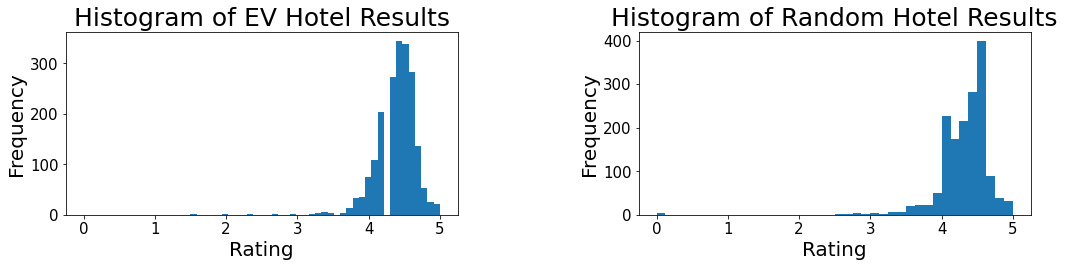

In [23]:
#Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,7), sharex=True, sharey=False)
fig.tight_layout(pad=15.0)
bins_num = 40

ax[0].hist(pd_hotels_db_useful['rating'], bins = bins_num)
ax[1].hist(pd_hotels_random['rating'], bins = bins_num)

ax[0].set_xlabel('Rating', size = 20)
ax[0].set_ylabel('Frequency', size = 20)
ax[0].set_title('Histogram of EV Hotel Results', size = 25)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].set_xlabel('Rating', size = 20)
ax[1].set_ylabel('Frequency', size = 20)
ax[1].set_title('Histogram of Random Hotel Results', size = 25)
ax[1].tick_params(axis='both', which='major', labelsize=15)

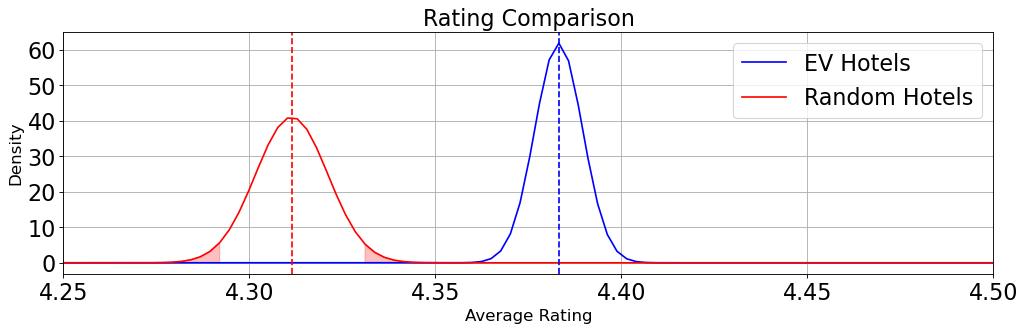

In [33]:
#Listing the various results from the data
x = np.linspace(3.5,4.8,500)
ev_pdf = stats.norm.pdf(x, ev_mean, ev_std_err) # the normal pdf for EV data
random_pdf = stats.norm.pdf(x, random_mean, random_std_err) # the normal pdf for random data

#Plot the two normal distributions 
plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, ev_pdf, label='EV Hotels', color = 'b')
plt.plot(x, random_pdf, label='Random Hotels', color = 'r')
plt.xlabel('Average Rating', size = 15)
plt.ylabel('Density', size = 15)
plt.title('Rating Comparison', size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlim(4.25, 4.5)
plt.grid()
plt.legend(fontsize=20)

#Visually show the mean for both distributions
plt.axvline(ev_mean, ymax=4, linestyle="--", color='b')
plt.axvline(random_mean, ymax=4, linestyle="--", color='r')

#Visually show the Alpha values in red
plt.fill_between(x, random_pdf, where=(x >= random_mean+random_std_err*1.96), color="r", alpha=0.25)
plt.fill_between(x, random_pdf, where=(x <= random_mean-random_std_err*1.96), color="r", alpha=0.25)

plt.show()

In [34]:
#Export data to CSV
#pd_hotels_db_useful.dropna().replace(',','', regex=True).to_csv('CSV_Files/ev_hotels.csv')
#pd_hotels_random.dropna().replace(',','', regex=True).to_csv('CSV_Files/random_hotels.csv')

# Separte the results into US Regions and compile the results

In [97]:
#Create variables to work with the regions results
ev_regions = pd_hotels_db_useful.dropna().groupby('regions')
random_regions = pd_hotels_random.dropna().groupby('regions')
results_regions = (random_regions.describe().iloc[:,[0,1,2]]).merge((ev_regions.describe().iloc[:,[0,1,2]]), left_on='regions', right_on='regions')
results_regions.columns = ['random_count', 'random_mean', 'random_std', 'ev_count', 'ev_mean', 'ev_std']

#Create dictionaries of the values within the two dataframes 
ev_dict = {}
random_dict = {}

for reg, val in ev_regions:
    ev_dict[reg] = val['rating'].to_numpy()

for reg, val in random_regions:
    random_dict[reg] = val['rating'].to_numpy()

#Use Welch T-Test for all regions and add it to the results dataframe
region_results = {}
for key, val in random_dict.items():
    t,p = stats.ttest_ind(val, ev_dict[key], equal_var = False)
    region_results[key] = p

#N - North East W - West M - Mid West S - South
results_regions.index = ['Mid West', 'North East', 'South', 'West']    
    
#Add p_value column
results_regions['p_values'] = pd.Series(region_results)

#Add difference in means column
results_regions['diff_means'] = results_regions['ev_mean'] - results_regions['random_mean']

#Determine cost for hotels to increase their rating by 0.01 of a point based on EV charger cost for 
#a Level 2 charger at avg price of $3500 per port, assuming a hotel would need 8 chargers ($28,000 total)
#(https://afdc.energy.gov/files/u/publication/evse_cost_report_2015.pdf)
results_regions['price_per_0.01'] = 28000 / (results_regions['diff_means'] * 100)

#Results breakdown using 'region'
results_regions = results_regions.reset_index()
results_regions.columns.values[0] = "region"

In [98]:
results_regions.iloc[:,[0,8,9]]

,region,diff_means,price_per_0.01
0,Mid West,0.038738,7228.059236
1,North East,0.087342,3205.778192
2,South,0.041072,6817.375786
3,West,0.101376,2761.983745


# Separte the results into US States and compile the results

In [73]:
#Create variables to work with the state results
ev_states = pd_hotels_db_useful.dropna().groupby('state')
random_states = pd_hotels_random.dropna().groupby('state')
results_state = (random_states.describe().iloc[:,[0,1,2]]).merge((ev_states.describe().iloc[:,[0,1,2]]), left_on='state', right_on='state')
results_state.columns = ['random_count', 'random_mean', 'random_std', 'ev_count', 'ev_mean', 'ev_std']
#results_state

#Create dictionaries of the values within the two dataframes 
ev_dict2 = {}
random_dict2 = {}

for st, val in ev_states:
    ev_dict2[st] = val['rating'].to_numpy()

for st, val in random_states:
    random_dict2[st] = val['rating'].to_numpy()

#Use Welch T-Test for all states and add it to the results dataframe
state_results = {}
for key, val in random_dict2.items():
    if key in ev_dict2:
        t,p = stats.ttest_ind(val, ev_dict2[key], equal_var = False)
        state_results[key] = p

#Add p_value column
results_state['p_values'] = pd.Series(state_results)

#Add difference in means column
results_state['diff_means'] = results_state['ev_mean'] - results_state['random_mean']

#Determine cost for hotels to increase their rating by 0.01 of a point based on EV charger cost for 
#a Level 2 charger at avg price of $3500 per port, assuming a hotel would need 8 chargers ($28,000 total)
#(https://afdc.energy.gov/files/u/publication/evse_cost_report_2015.pdf)
results_state['price_per_0.01'] = 28000 / (results_state['diff_means'] * 100)

#Get rid of the negative values, the very high values, and rows with less than 
results_state.drop(results_state.loc[results_state['price_per_0.01']<=0].index, inplace=True)
results_state['price_per_0.01'] = results_state['price_per_0.01'].apply(lambda x: 30000 if x>30000 else x)
results_state.drop(results_state.loc[results_state['random_count']<5].index, inplace=True)
results_state.drop(results_state.loc[results_state['ev_count']<5].index, inplace=True)

#Results breakdown using 'state'
results_state = results_state.reset_index()
results_state.columns.values[0] = "State_code"
results_state = results_state.round(2)
results_state

/home/louisbove84/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/louisbove84/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



,State_code,random_count,random_mean,random_std,ev_count,ev_mean,ev_std,p_values,diff_means,price_per_0.01
0,AZ,46.0,4.36,0.22,64.0,4.37,0.23,0.91,0.00,30000.00
1,CA,285.0,4.22,0.49,444.0,4.37,0.31,0.00,0.15,1837.31
2,CO,29.0,4.44,0.16,94.0,4.47,0.31,0.53,0.03,10082.96
3,CT,12.0,4.34,0.17,17.0,4.39,0.24,0.50,0.05,5338.32
4,FL,151.0,4.27,0.33,231.0,4.38,0.31,0.00,0.12,2390.69
5,GA,34.0,4.33,0.23,105.0,4.42,0.25,0.05,0.09,3058.75
6,IA,21.0,4.14,0.59,6.0,4.32,0.31,0.33,0.18,1568.00
7,KS,16.0,4.45,0.24,8.0,4.53,0.32,0.57,0.08,3733.33
8,KY,9.0,4.38,0.16,32.0,4.39,0.21,0.88,0.01,28800.00
9,MA,40.0,4.37,0.27,11.0,4.45,0.07,0.08,0.09,3216.71


# Create Dash Choropleth for the results

In [74]:
    #Copy dfs
    region_df = results_regions.copy()
    state_df = results_state.copy()

In [75]:
    px.choropleth(
        data_frame=state_df,
        locationmode='USA-states',
        scope="usa",
        locations='State_code',
        template='plotly',
        color='price_per_0.01',
        color_continuous_scale=px.colors.sequential.YlOrRd,
        height=500,
        title='Price to Increase Hotel Rating by 0.01 Stars (USD)'
        )

In [79]:
    px.choropleth(
        data_frame=state_df,
        locationmode='USA-states',
        scope="usa",
        locations='State_code',
        template='plotly',
        color='diff_means',
        color_continuous_scale='aggrnyl',
        height=500,
        title='Expected Increase in Hotel Rating due to Addition of EV Charging Station'
        )